In [2]:
%matplotlib widget
%matplotlib widget
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
import ipywidgets as widgets

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import get_sun

import matplotlib.colors as colors
import matplotlib.cm as cmx

import datetime

#download the latest IERS predictions by running:
from astropy.utils.data import download_file
from astropy.utils import iers
iers.IERS.iers_table = iers.IERS_A.open(download_file(iers.IERS_A_URL, cache=True))

In [3]:
def calc(obj, loc, midnight, delta_midnight):

        rad = np.pi/180.

        # - altitutde and azimuth -#
        altaz = obj.transform_to(AltAz(obstime=midnight+delta_midnight, location = loc))
        alt = np.array((altaz.alt)*u.deg)
        az = np.array((altaz.az)*u.deg)

        # rotation speed
        rot_speed = (15.0417827*np.cos(loc.lat.deg*rad)*np.cos(az*rad))/np.cos(alt*rad)

        # - return label array -
        label = np.array(obj.dec*u.deg)
        #print np.array(altaz.obstime)
        return alt, az, rot_speed, label

In [4]:
# ## FIELD ROTATION PROGRAM -- MARSEILLE TESTING ##
# #- transform from ra dec to altitude azimuth -#
# # loc = EarthLocation(lat = 34.64*u.deg, lon = 255.758*u.deg, height = 0.0*u.m)
# # lat = 34.4714
# # lon = 255.758

# # #FtSumner##
# loc = EarthLocation(lat = 34.404377*u.deg, lon = -104.193565*u.deg, height = 1211*u.m)
# lat = 34.404377
# lon = -104.193565

# #TOULOUSE##
loc = EarthLocation(lat = 43.6042600*u.deg, lon = 1.4436700*u.deg, height = 150*u.m)
lat = 43.6042600
lon = 1.4436700
print(loc)
loc.lat.deg

(4624551.24800758, 116548.53465727, 4376460.44018321) m


43.60425999999999

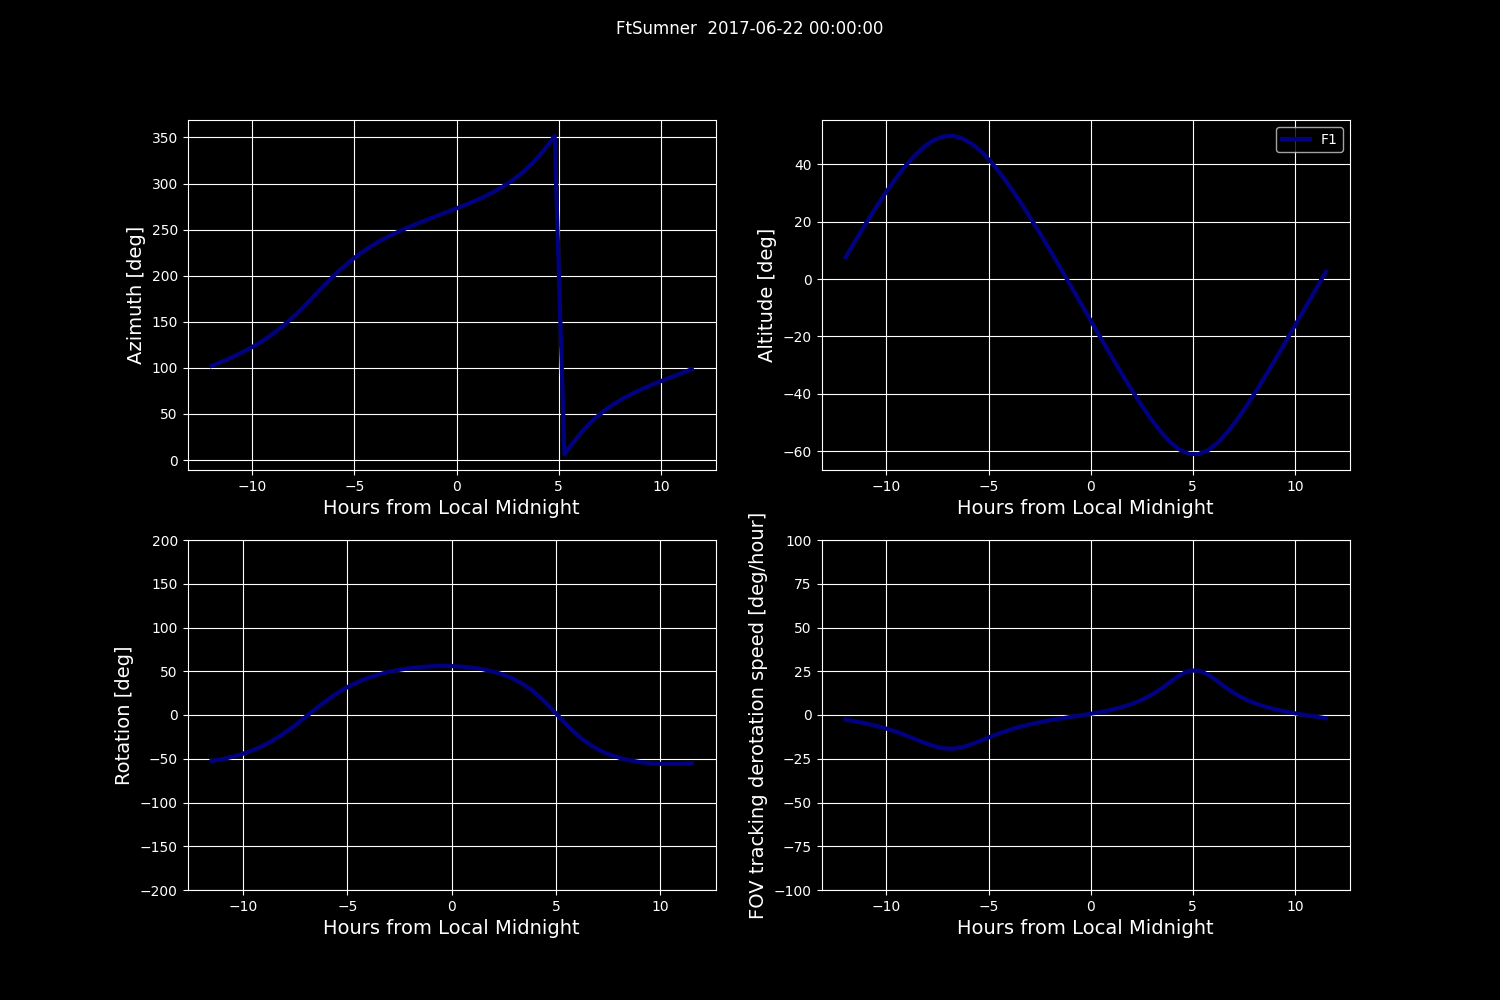

In [5]:


style={}#{'description_width': 'initial'} 
width = '400px'
continuous_update=True


class dashboard(widgets.HBox):
     
    def __init__(self):
        super().__init__()
        self.output = widgets.Output()
        
        # self.ax1bis = self.ax1.twinx()

        #location FTS        
        self.lat = 34.404377
        self.lon = -104.193565
        self.height = 1211
        self.loc = EarthLocation(lat = self.lat*u.deg, lon = self.lon*u.deg, height = self.height*u.m)

        #- set date/time and UTC offset -#
        # #FtSumner##
        # utcoffset = 6.0*u.hour
        # midnight = Time('2017-9-20 00:00:00') + utcoffset
        # delta_midnight = np.linspace(-12, 12, 100000)*u.hour

        #TOULOUSE##
        self.utcoffset = 2.0*u.hour
        self.date = '2017-6-22'
        self.midnight = Time(self.date+' 00:00:00') - self.utcoffset
        self.n=5000
        self.delta_midnight = np.linspace(-12, 12, self.n)*u.hour
        #TODO add ,"Moon", 'Sun', 'F2',"m31"
        self.targets = widgets.Select(options=["F1", 'F2', 'F3',"F4","QSO1","QSO2","QSO3","QSO4","BQSO1","BQSO2","BQSO3"],rows=3,description='Targets',disabled=False)#,value=["F1"]
        self.date = widgets.DatePicker(description='Obs Date',disabled=False,value=datetime.date (2017, 6, 22))
        self.location = widgets.Select(options=["Toulouse", 'FtSumner', 'Marseille',"Pasadena"],value="FtSumner",rows=3,description='Loc',disabled=False)
        wids = widgets.interactive(self.update,targets=self.targets,date=self.date,location=self.location)
        controls = VBox([HBox([self.targets,self.date,self.location])] )
        display(HBox([self.output,controls]))



        #- Calcuate call -#

        ##VIPERS: F1M1 center 32.19, -5.688 
        ##DEEP2: F2M2 center 252.6298, 34.85245
        ##DEEP2: F3M3 center 352.3424, 0.21245
        ##DEEP2: F4M4 center 36.9049, 0.65245

        #obj = SkyCoord(ra = [260.0, 37.0, 34.5, 353.0, 253.0]*u.deg, dec = [60.0, 1.0, -5.2, -0.1, 35.0]*u.deg)
        #num = 5
        #         label = ['SRTF12', 'DEP2-4', 'VIPERS', 'PMS-D3', 'DEP2-2']
        # label = ['F1M1', 'F2M2', 'F3M3', 'F4M4']
        self.label = ['F1', 'F2', 'F3', 'F4',"QSO1","QSO2","QSO3","QSO4","BQSO1","BQSO2","BQSO3"]

        # num = 4



# - plotting routine -#
        self.compute_all_info(self.targets.value)
        num = len(self.obj)
        self.fig, self.ax = plt.subplots(2,2,figsize = (15,10))
        # self.fig=fig
        ax=self.ax
        # fig.suptitle(loc)
        # fig.suptitle('FIREBall-2 Field Rotation (Toulouse 6-22-2017 Lat = '+ str(lat) + r'$\rm^{\circ}N$' +', Lon = ' + str(lon) + r'$\rm ^{\circ}E$' +')', fontsize = 16)
        self.fig.suptitle(self.location.value + '  %s 00:00:00'%(self.date.value.strftime("%Y-%m-%d")))

        jet = cm = plt.get_cmap('jet') 
        cNorm  = colors.Normalize(vmin=0, vmax=num)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

        self.hour = np.array(self.delta_midnight)
        skip = np.arange(0, self.az_new.shape[1], 100)
        ls="-"
        for i, l in zip(range(num), self.label):
        
                colorVal = scalarMap.to_rgba(i)
                colorText = (
                'color: (%4.2f,%4.2f,%4.2f)'%(colorVal[0],colorVal[1],colorVal[2])
                )
                self.ax_az = self.ax[0,0].plot(self.hour[::100], self.az_gray[num-1-i,skip], ls, c = colorVal, lw = 3, label = l)
                # self.ax_az = self.ax[0,0].plot(self.hour, self.az_new[num-1-i], c = colorVal, lw = 3, label = l)
                self.ax_alt = self.ax[0,1].plot(self.hour[::100], self.alt_gray[num-1-i,skip], ls, c = colorVal, lw = 3, label = l)
                # self.ax_alt = self.ax[0,1].plot(self.hour, self.alt_new[num-1-i],  c = colorVal, lw = 3, label = l)
                self.ax_rs = self.ax[1,1].plot(self.hour[::100], self.rs_gray[num-1-i,skip], ls, c = colorVal, lw = 3, label = l)
                # self.ax_rs = self.ax[1,1].plot(self.hour, self.rs_new[num-1-i], c = colorVal, lw = 3, label = l)
                self.ax_rt = self.ax[1,0].plot(self.hour[::100][1:], self.rt_gray[num-1-i,skip][1:], ls, c = colorVal, lw = 3, label = l)
                # self.ax_rt = self.ax[1,0].plot(self.hour, self.rt_new[num-1-i],  c = colorVal, lw = 3, label = l)

        ax[0,0].set_xlabel('Hours from Local Midnight', fontsize = 14)
        ax[0,0].set_xlabel('Hours from Local Midnight', fontsize = 14)
        ax[0,1].set_xlabel('Hours from Local Midnight', fontsize = 14)
        ax[0,1].set_ylabel('Altitude [deg]', fontsize = 14)
        ax[0,0].set_ylabel('Azimuth [deg]', fontsize = 14)
        ax[1,1].set_ylabel('FOV tracking derotation speed [deg/hour]', fontsize = 14)
        ax[1,1].set_xlabel('Hours from Local Midnight', fontsize = 14)
        ax[1,0].set_xlabel('Hours from Local Midnight', fontsize = 14)
        ax[1,0].set_ylabel('Rotation [deg]', fontsize =14)

        ax[1,0].set_ylim(-200,200)
        ax[1,1].set_ylim(-100,100)

        ax[0,1].legend()

        ax[0,0].grid()
        ax[1,1].grid()
        ax[0,1].grid()
        ax[1,0].grid()
        # plt.show()
  



    def compute_all_info(self,targets):
        obj = SkyCoord(ra = [32.19,252.6298,352.3424,36.9049,0.03894,22.42638,14.62883,351.8533,275.48,234.89,11.865604]*u.deg, dec = [-5.688,34.85245,0.21245,0.65245,1.39459,0.62279,0.00512,-1.8553,64.36,47.59,3.244401]*u.deg)
        self.obj=[obj[self.label.index(targets)]]#[self.obj[label==self.targets.value]]
        # print(targets,self.obj, self.label[self.label.index(targets)] )

        midnight =self.midnight
        delta_midnight =self.delta_midnight
        alt = []
        az = []
        rs = []
        label = []
        num = len(self.obj)
        for i in range(0,len(self.obj)):
                a,z,s,l = calc(self.obj[i], self.loc, self.midnight, self.delta_midnight)
                alt.append(a)
                az.append(z)
                rs.append(s)
                label.append(l)

        hour = np.array(self.delta_midnight)
        alt = np.array(alt)
        az = np.array(az)
        rs = np.array(rs)

        # - now calculate/integrate absolute field rotation -#
        rt = []
        for i in range(0,len(self.obj)):
                if(any(alt[i] != 0) == True):
                        zero = np.argmax(alt[i])
                        # print alt[i,zero]
                        index1 = np.arange(0, zero)
                        index2 = np.arange(zero, rs.shape[1])

                        r_b = rs[i, index1]
                        r_a = rs[i, index2]
                        
                        rot_before = np.zeros(np.size(r_b))
                        rot_after = np.zeros(np.size(r_a))

                        #rot_before[np.size(r_b)] = 0
                        step = 24./np.size(hour)
                        rot_after[0] = 180.
                        for j in range(1, np.size(r_a)):
                                rot_after[j] = (rot_after[j-1] - (r_a[j-1]*step))

                        rot_before[np.size(r_b) - 1] = -180.
                        for j in range(2, np.size(r_b)):
                                k = np.size(r_b) - j
                                rot_before[k] = (rot_before[k+1] +(r_b[k+1]*step))

                        #rot_before = np.zeros(np.size(r_b))
                        # IF THE DECLINATION IS LESS THAN THE LATITUDE
                        rot_after =  rot_after - 180.
                        rot_before = rot_before + 180.

                        final = np.hstack((rot_before, rot_after))

                        rt.append(final)
                else:
                        rt.append(np.zeros(rs.shape[1]))                                 


        rt = np.array(rt)
        #print hour
        # - get sun - #
        altazframe = AltAz(obstime = midnight+delta_midnight, location = self.loc)
        sun  = get_sun(midnight+delta_midnight).transform_to(altazframe)
        sun_index = np.where(sun.alt > 0)
        #n = 100000
        self.alt_new = alt.copy()
        self.az_new = az.copy()
        self.rt_new =  rt.copy()
        self.rs_new = rs.copy()
        self.alt_gray = self.alt_new.copy()
        self.az_gray = self.az_new.copy()
        self.rt_gray =  self.rt_new.copy()
        self.rs_gray = self.rs_new.copy()
        #- fireball limits #
        for i in range(0, len(self.obj)):
                min = np.where(alt[i] < 40)
                max = np.where(alt[i] >= 71)
                self.alt_new[i,min] = np.nan
                self.alt_new[i,max] = np.nan
                self.az_new[i, min] = np.nan
                self.az_new[i, max] = np.nan
                self.rt_new[i, min] = np.nan
                self.rt_new[i, max] = np.nan
                self.rs_new[i, min] = np.nan
                self.rs_new[i, max] = np.nan

                self.alt_new[i, sun_index] = np.nan
                self.az_new[i, sun_index] = np.nan
                self.rt_new[i, sun_index] = np.nan
                self.rs_new[i, sun_index] = np.nan
        return self
        






    def update(self,targets,date, location ):
        """Draw line in plot"""
        with self.output:
            location=="Marseille"
            a0, a1, a2, a3 = self.ax.flatten()
            if location=="Marseille":
                self.utcoffset = 2.0*u.hour
                self.lat = 43.3722
                self.lon = 5.3638
                self.height = 150

            elif location=="FtSumner":
                self.utcoffset = 6.0*u.hour
                self.lat = 34.404377
                self.lon = -104.193565
                self.height = 1211


            elif location=="Toulouse":
                self.utcoffset = 2.0*u.hour
                self.lat = 43.6042600
                self.lon = 1.4436700
                self.height = 150

            elif location=="Pasadena":
                self.utcoffset = 7 *u.hour
                self.lat = 34.147781
                self.lon = 118.144524
                self.height = 272
            else:
                raise(ValueError)

            self.delta_midnight = np.linspace(-12, 12, self.n)*u.hour
            self.loc = EarthLocation(lat = self.lat*u.deg, lon = self.lon*u.deg, height = self.height*u.m)
            self.midnight = Time('%s 00:00:00'%(date.strftime("%Y-%m-%d"))) - self.utcoffset


            self.compute_all_info(targets)
            num = len(self.obj)
            skip = np.arange(0, self.az_new.shape[1], 100)

            for i, l in zip(range(num),  self.label):
                # print(len(self.hour),len(self.az_new[num-1-i]))
                # print(self.ax_az [0].get_data())
                self.ax_az [0].set_data(self.hour[::100],  self.az_gray[num-1-i,skip])
                self.ax_alt[0].set_data(self.hour[::100], self.alt_gray[num-1-i,skip])
                self.ax_rs [0].set_data(self.hour[::100],  self.rs_gray[num-1-i,skip])
                self.ax_rt [0].set_data(self.hour[::100][1:],  self.rt_gray[num-1-i,skip][1:])

        #     self.fig.suptitle('FIREBall-2 Field Rotation (%s Lat = ' r'$\rm^{\circ}N$' +', Lon = ' + str(lon) + r'$\rm ^{\circ}E$' +')', fontsize = 16)

            self.fig.suptitle(location + '  %s'%(date.strftime("%Y-%m-%d")))
            self.fig.canvas.draw()
        self.axes = a0, a1, a2, a3 
        return 

d = dashboard()

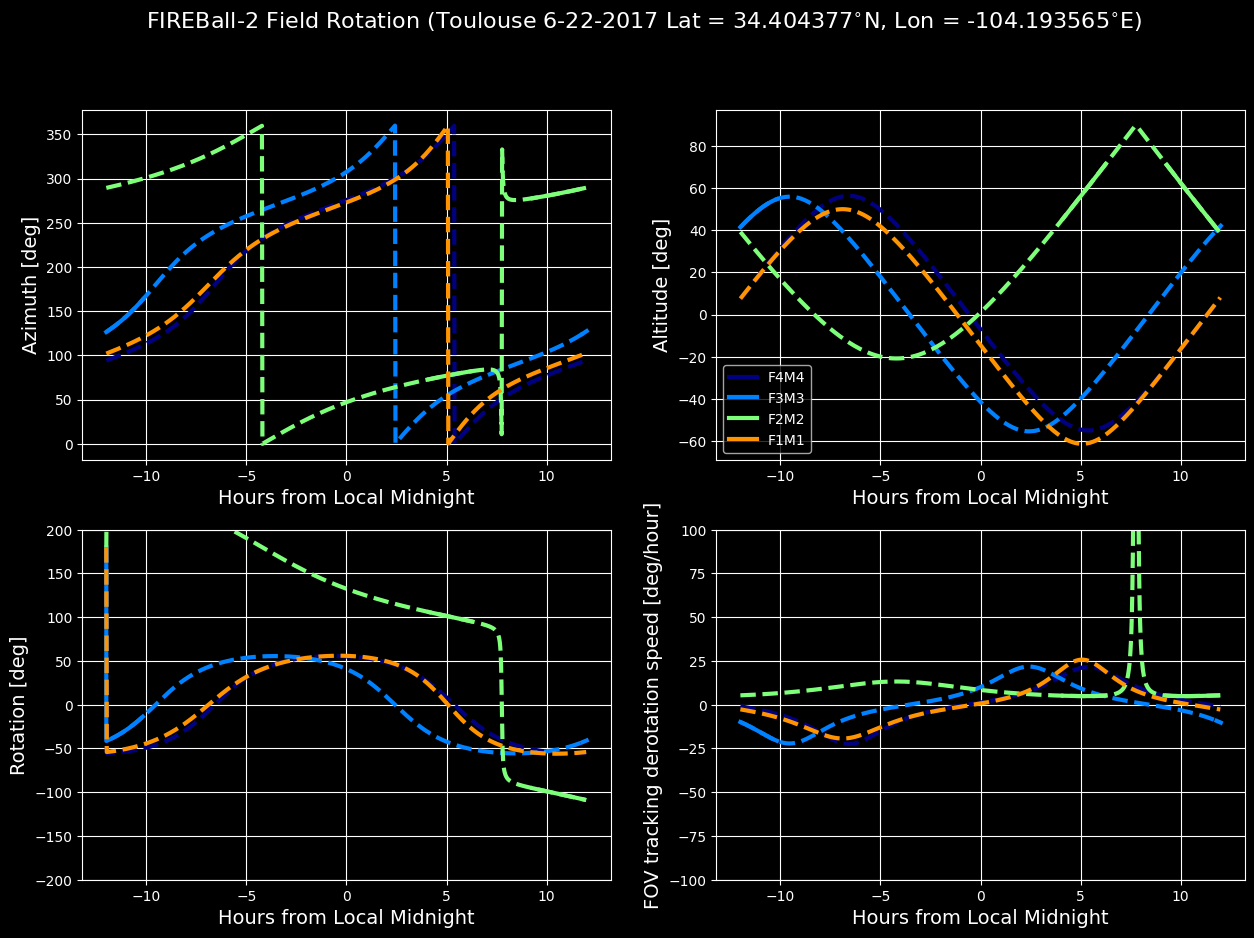

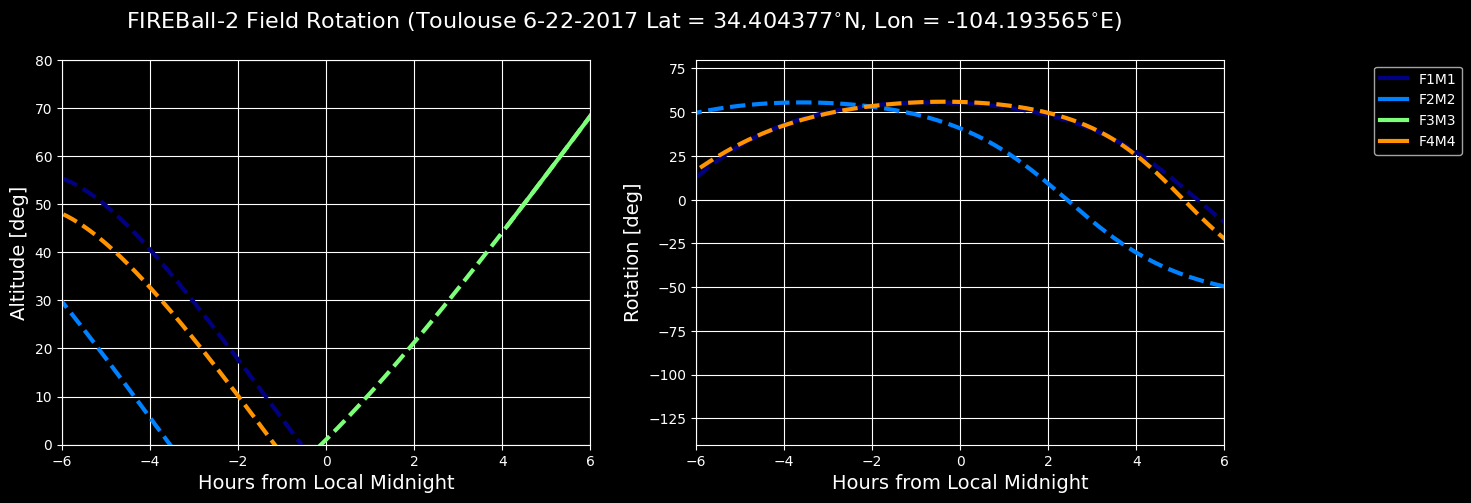

In [15]:
# # - plotting routine -#

# fig, ax = plt.subplots(1,2,figsize = (15, 5))
# #fig.suptitle('FIREBall-2 Field Rotation (Ft Sumner 9-20-2017 Lat = '+ str(lat) + r'$\rm^{\circ}N$' +', Lon = ' + str(lon) + r'$\rm ^{\circ}E$' +')', fontsize = 16)
# fig.suptitle('FIREBall-2 Field Rotation (Toulouse 6-22-2017 Lat = '+ str(lat) + r'$\rm^{\circ}N$' +', Lon = ' + str(lon) + r'$\rm ^{\circ}E$' +')', fontsize = 16)

# jet = cm = plt.get_cmap('jet') 
# cNorm  = colors.Normalize(vmin=0, vmax=num)
# scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

# #label = ['SRTF12', 'DEP2-4', 'VIPERS', 'PMS-D3', 'DEP2-2']
# label = ['F1M1', 'F2M2', 'F3M3', 'F4M4']

# skip = np.arange(0, az.shape[1], 100)
# for i, l in zip(range(num), label):
    
#         colorVal = scalarMap.to_rgba(i)
#         colorText = (
#             'color: (%4.2f,%4.2f,%4.2f)'%(colorVal[0],colorVal[1],colorVal[2])
#             )
#         # print colorVal
        
#         ax[0].plot(hour[::100], alt_gray[num-1-i,skip], c=colorVal, ls = '--', lw = 3)
#         ax[0].plot(hour, alt_new[num-1-i],  c = colorVal, lw = 3, label = l)
#         #ax[0].fill_between(hour, alt_new[num-1-i], facecolor=colorVal, alpha=0.2, interpolate = True)
#         ax[1].plot(hour[::100], rt_gray[num-1-i,skip],  c = colorVal, ls = '--', lw = 3)
#         ax[1].plot(hour, rt_new[num-1-i],  c = colorVal, lw = 3, label = l)

# ax[0].set_xlabel('Hours from Local Midnight', fontsize = 14)
# ax[0].set_ylabel('Altitude [deg]', fontsize = 14)

# ax[1].set_xlabel('Hours from Local Midnight', fontsize = 14)
# ax[1].set_ylabel('Rotation [deg]', fontsize =14)

# ax[0].set_xlim((-6,6))
# ax[1].set_xlim((-6,6))

# ax[0].set_ylim(0,80)
# ax[1].set_ylim(-140,80)

# ax[1].legend(bbox_to_anchor = (1.27,1))

# ax[0].grid()
# ax[1].grid()

# plt.savefig('xfieldrotation2.png')
# plt.show()